## Imports and initializations

In [1]:
import numpy as np
import signac as sg
import pickle
from itertools import product, combinations, accumulate, groupby
from matplotlib import pyplot as plt
from matplotlib import cm, colors
from matplotlib.ticker import PercentFormatter
from project import spherical_to_cartesian, get_cross_limits
import sys
import os

In [2]:
project = sg.get_project()

# Read in shared data
sd_fn = project.fn('shared_data.h5')
with sg.H5Store(sd_fn).open(mode='r') as sd:
    adj_mats = np.array(sd['adj_mats'])
    modules = np.array([i.decode() for i in sd['modules']])
    cross_labels = np.array([i.decode() for i in sd['cross_labels']])
    C_offdiags = list(sd['C_offdiags'])

n_cross_arr = np.arange(0, len(C_offdiags)+1)
C_elements = np.array(C_offdiags + [[i,i] for i in range(3)])
constraint_keys = ['unconstrained', 'constrained']

In [3]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = ['Computer Modern Sans Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.weight'] = 'light'

## Total robustness (Fig 2)

In [415]:
savefig = True
figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
figfn = 'fig2.pdf' 
# figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/final/'
# figfn = 'fig2.png' 
constraint_keys = ['unconstrained', 'constrained']
axfontsize = 40
num_subplots = len(modules)
markersize = 17
markeralp = 1.
linewidth = 5.75
xmargin = 0.1
ymargin = 0.03
ticklabelsize = 30
ticklength = 8
tickwidth = 2.5
colors = ['#D09001', '#58988B', '#9A3D47', '#62ACDA']
hatchstyle = '/'
dpi = 500
fig, axs = plt.subplots(2, 2, figsize=(10.5*2, 8.5*2), layout='constrained', 
                        sharey=True, dpi=dpi)
with sg.H5Store('robustness.h5').open(mode='r') as rob_data:
    # Reorder modules to fit Fig. 1
    for module_idx, module in enumerate(modules[[0,2,1,3]]):
        row = 0 if module_idx < 2 else 1
        col = 0 if module_idx in [0,2] else 1
        unstable_rob = float(rob_data['{}/robustness/unstable'.format(module)])
        for cons_key in constraint_keys:
            data_key = '{}/robustness/total/{}'.format(module, cons_key)
            data = np.array(rob_data[data_key])
            ls = '--' if cons_key == 'unconstrained' else '-'
            axs[row, col].plot(n_cross_arr, data, ls=ls, lw=linewidth, color=colors[module_idx], zorder=1, 
                               marker='o', markersize=markersize)
        axs[row, col].set_ylim(0-ymargin, 1)
        labelleft = False if col==1 else True
        axs[row, col].fill_between(np.arange(-1,8), y1=1, y2=1-unstable_rob, facecolor='none', alpha=0.6, 
                                   hatch=hatchstyle, edgecolor='black')
        axs[row, col].axhline((1 - unstable_rob)/2, alpha=0.6, color='grey', 
                              linewidth=0.5*linewidth, zorder=-1)
        axs[row, col].set_xlim(0-xmargin, 6+xmargin)
        xlim = [0,4] if module_idx < 3 else [0,6]
        axs[row, col].set_xlim(xlim[0] - xmargin, xlim[1] + xmargin)
        axs[row, col].set_xticks(range(xlim[1]+1))
        axs[row, col].tick_params(labelsize=ticklabelsize, labelleft=labelleft,
                                  length=ticklength, width=tickwidth)
        # Add legend if upper right subplot
        if module_idx == 1:
            axs[row, col].plot([], [], ls='--', lw=linewidth, color='black', label='unconstrained',
                               marker='o', markersize=markersize*0.9)
            axs[row, col].plot([], [], ls='-', lw=linewidth, color='black', label='constrained',
                               marker='o', markersize=markersize*0.9)
            axs[row, col].legend(bbox_to_anchor=(1., 0.935), fontsize=ticklabelsize*0.9, 
                                 framealpha=1, handlelength=3.)
fig.supylabel(r'$\overline{\omega}_{pf}~\left(\bf{P},\bf{C}\right)$', fontsize=axfontsize, y=0.525)
fig.supxlabel(r'$n_{\rm cross}$', fontsize=axfontsize, x=0.525)
if savefig:
    plt.savefig(figpath + figfn, bbox_inches='tight')

## Variance and example distributions (Fig 3)

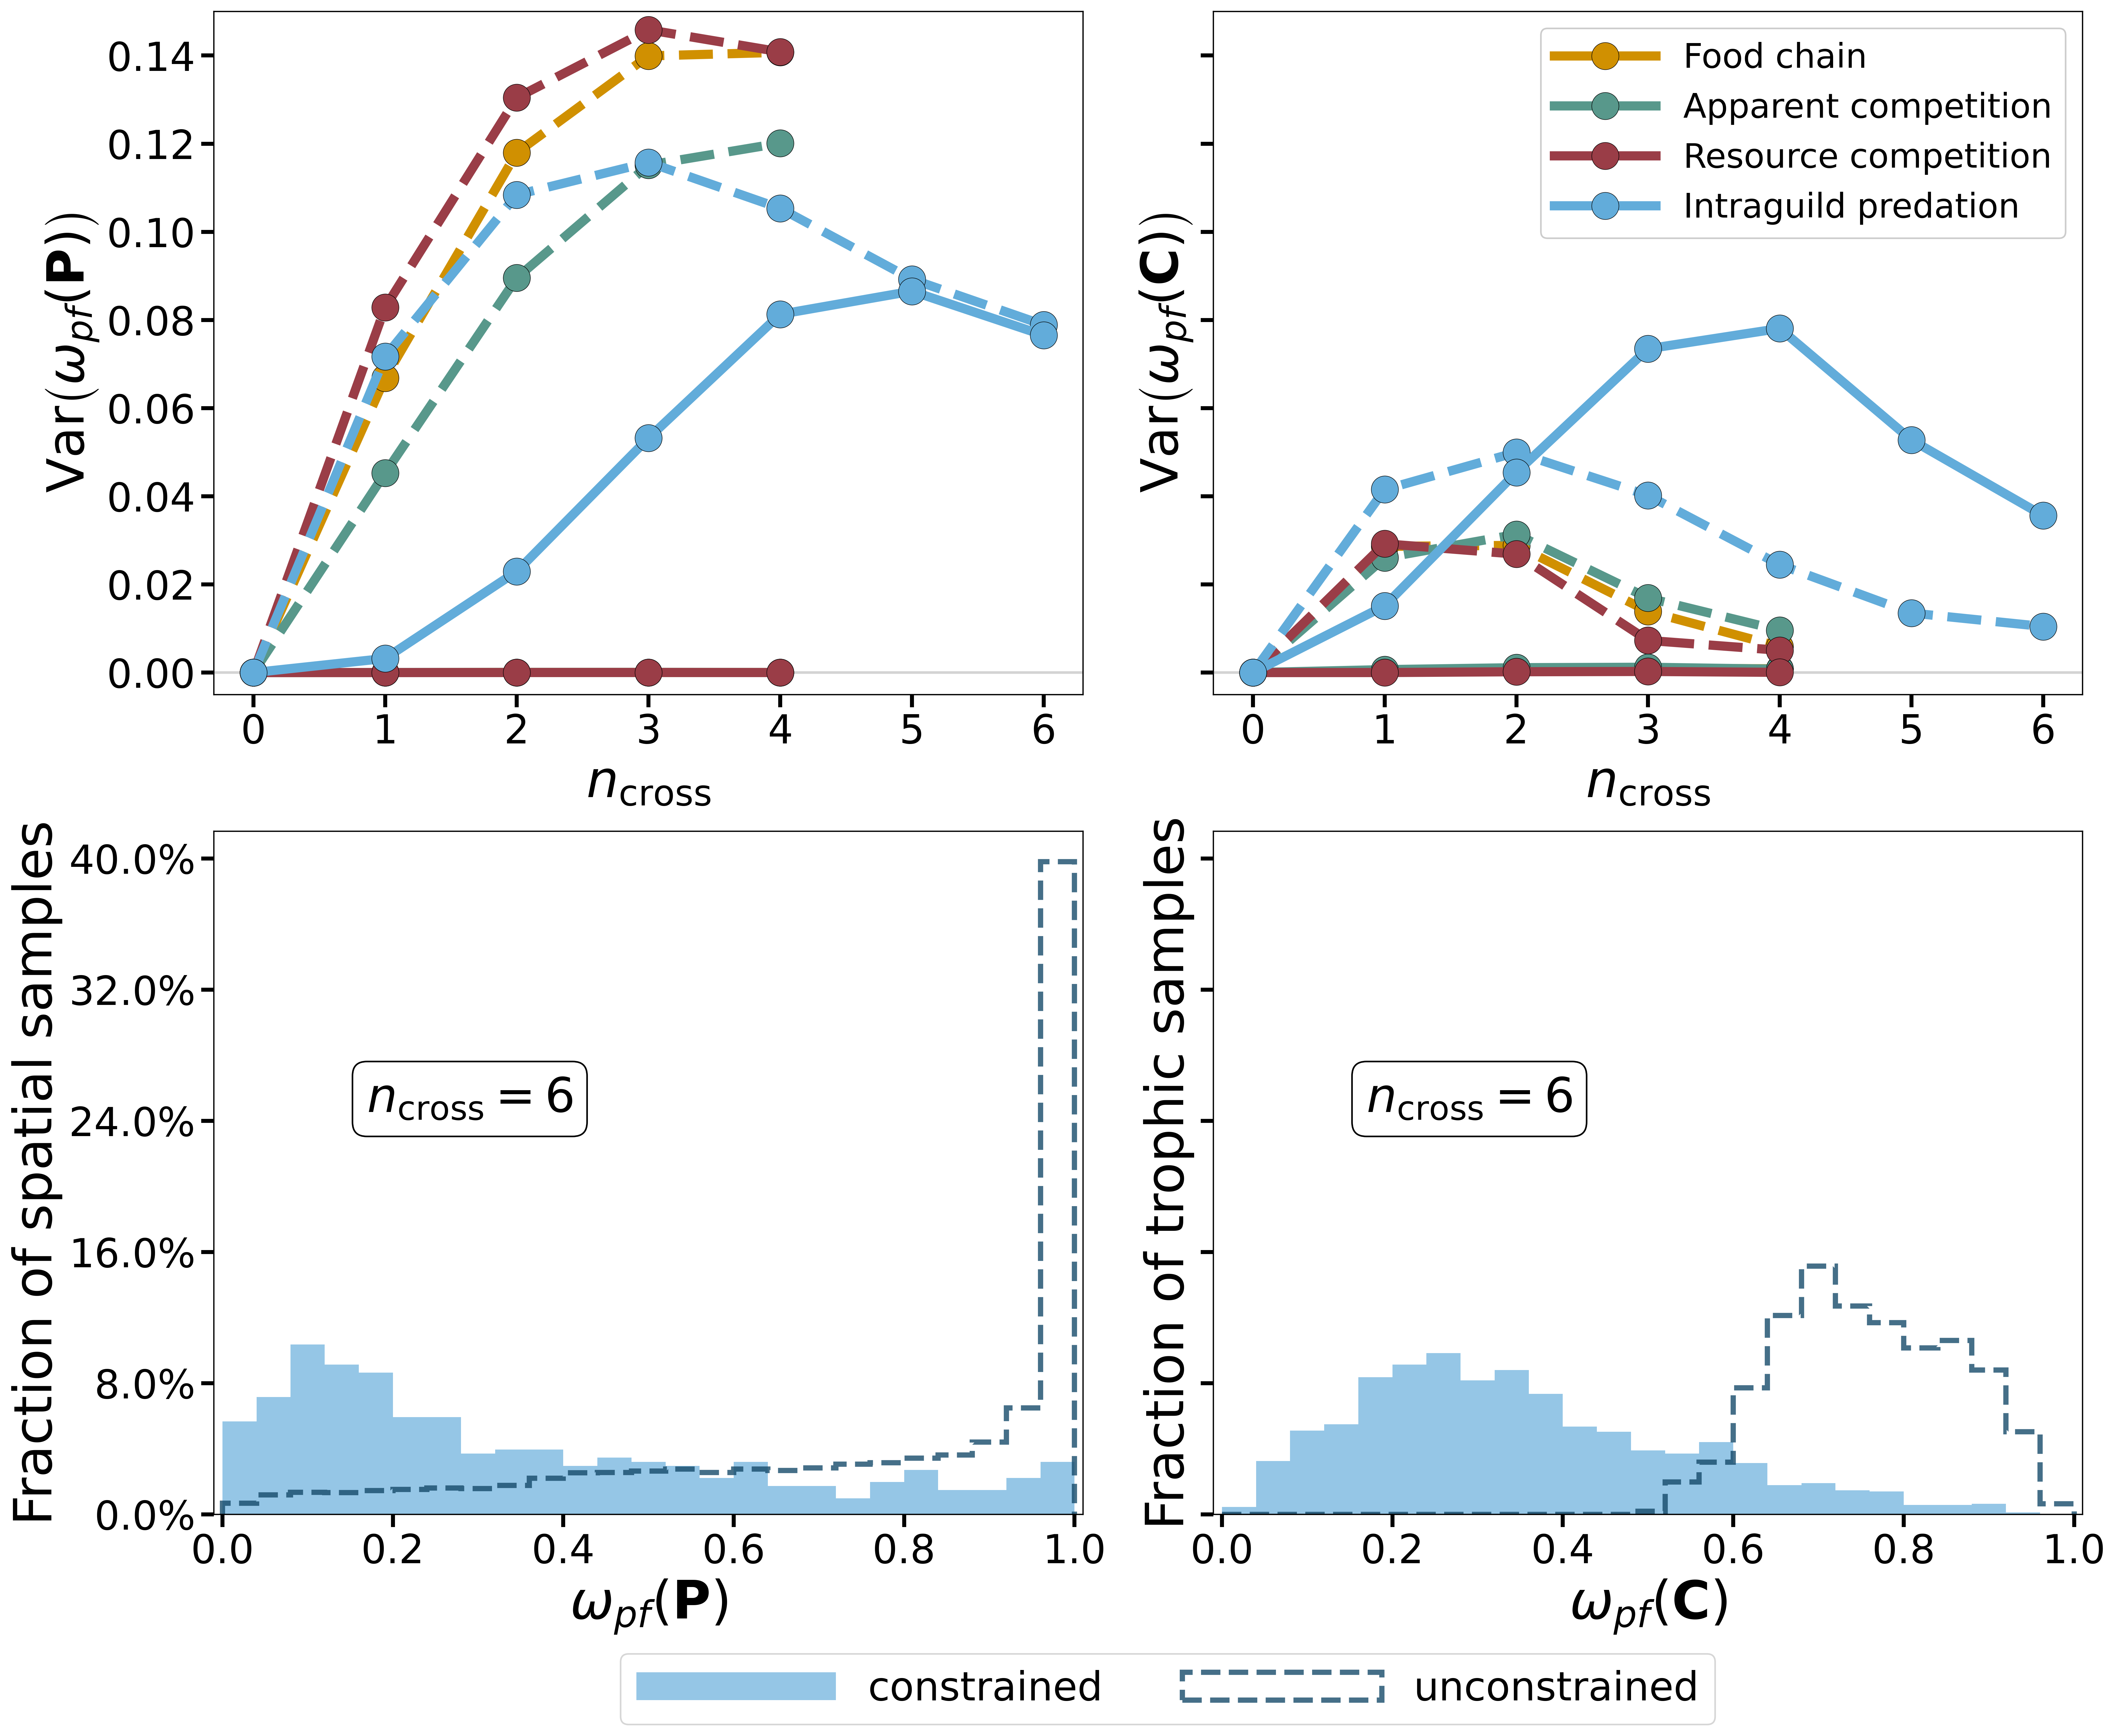

In [4]:
savefig = True
# figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
figfn = 'fig3.png'
figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/final/'
# figfn = 'fig3.pdf'
# Set new module labels because they've changed
modules_new = ['Food chain', 'Apparent competition', 'Resource competition', 'Intraguild predation']
letters = [r'$\left(\rm a\right)$', r'$\left(\rm b\right)$', 
           r'$\left(\rm c\right)$', r'$\left(\rm d\right)$']
let_x = -0.2
let_y = 1.0
num_bins = 25
axfontsize = 32
markersize = 17
linewidth = 5.75
ticklabelsize = 25
ticklength = 8
tickwidth = 2.5
colors = ['#D09001', '#58988B', '#9A3D47', '#62ACDA']
dist_light = '#95C6E6'
dist_dark = '#164B6B'
dpi = 400
fig, axs = plt.subplots(2, 2, figsize=(10.5*2, 8.5*2), dpi=dpi)
handles = []; labels = []
with sg.H5Store('robustness.h5').open(mode='r') as rob_data:
    for module_idx, module in enumerate(modules[[0,2,1,3]]):
        for rob_idx, rob_key in enumerate(['local', 'spatial']):
            # First plot the variance
            row = 0; col = rob_idx
            axs[row, col].axhline(0, ls='-', color='lightgrey', alpha=1., zorder=-1)
            for cons_key in constraint_keys:
                data_key = '{}/variance/{}/{}'.format(module,rob_key,cons_key)
                stat_data = np.array(rob_data[data_key])
                ls = '--' if cons_key == 'unconstrained' else '-'
                label = modules_new[module_idx]
                line = axs[row, col].plot(n_cross_arr, stat_data, ls=ls, lw=linewidth, color=colors[module_idx], 
                                          zorder=module_idx, marker='o', markersize=markersize, label=label, 
                                          markeredgecolor='black', markeredgewidth=0.3)
                if (cons_key == 'constrained') and (rob_idx == 1):
                    handles.append(line[0]); labels.append(label)
                axs[row, col].set_xlabel(r'$n_{\rm cross}$', fontsize=axfontsize)
                if rob_key == 'local':
                    ylabel = 'Var' + r'$\left(\omega_{pf}\left(\bf{P}\right)\right)$'
                else: 
                    ylabel = 'Var' + r'$\left(\omega_{pf}\left(\bf{C}\right)\right)$'
                axs[row, col].set_ylabel(ylabel, fontsize=axfontsize)
                ylim = (-0.005,0.15) 
                axs[row, col].set_ylim(ylim)
            left, labelleft = (False, False) if col==1 else (True, True)
            axs[row, col].tick_params(labelsize=ticklabelsize, length=ticklength, width=tickwidth, 
                                      labelleft=labelleft)
            # Annotate subplot labels
            # axs[row, col].annotate(letters[rob_idx], xy=(let_x+0.08*rob_idx, let_y), 
            #                        xycoords='axes fraction', size=axfontsize)
            
            # Now plot example distributions
            row = 1
            if module == 'omnivory':
                n_cross = 6
                # First plot constrained distribution
                data_key = '{}/robustness/{}/constrained/{}'.format(module,rob_key,str(n_cross))
                data = np.array(rob_data[data_key])
                label = 'constrained'
                con_dist = axs[row, col].hist(data, range=(0,1), bins=num_bins, 
                                           density=True, histtype='bar', linewidth=2, 
                                           color=dist_light, label=label)
                # Now plot unconstrained distribution
                data_key = '{}/robustness/{}/unconstrained/{}'.format(module,rob_key,str(n_cross))
                data = np.array(rob_data[data_key])
                label = 'unconstrained' 
                uncon_dist = axs[row, col].hist(data, range=(0,1), bins=num_bins, 
                        density=True, histtype='step', linewidth=linewidth/1.75, color=dist_dark, 
                        linestyle='--', alpha=0.8, label=label)
                # Annotate n_cross
                label = r'$n_{\rm cross}=$' + str(n_cross)
                axs[row, col].annotate(label, xy=(225, 275), xycoords='axes points',
                            size=30, ha='right', va='top',
                            bbox=dict(boxstyle='round', fc='w'))
                # Set misc plot parameters
                binsize = con_dist[1][1] - con_dist[1][0]
                maxN = 1 / binsize
                axs[row, col].set_ylim(0, maxN/2.4)
                axs[row, col].yaxis.set_major_formatter(PercentFormatter(xmax=maxN))
                axs[row, col].set_xlim(-0.01,1.01)
                if rob_key == 'local':
                    xlabel = r'$\omega_{pf}\left(\bf{P}\right)$'
                    ylabel = 'Fraction of spatial samples'
                else:
                    xlabel = r'$\omega_{pf}\left(\bf{C}\right)$'
                    ylabel = 'Fraction of trophic samples'
                axs[row, col].set_xlabel(xlabel, fontsize=axfontsize+1)
                axs[row, col].set_ylabel(ylabel, fontsize=axfontsize+1)
                
                # Plot legend underneath
                if rob_idx == 1:
                    axs[row, col].legend(bbox_to_anchor=(0.6, -0.175), handlelength=5, 
                                         fontsize=ticklabelsize*1.0, ncol=2)
            axs[row, col].tick_params(labelsize=ticklabelsize, length=ticklength, width=tickwidth, 
                                      labelleft=labelleft)
            # axs[row, col].annotate(letters[rob_idx+2], xy=(let_x+0.08*rob_idx, let_y+0.05), xycoords='axes fraction', size=axfontsize)
axs[0,1].legend(handles, labels, fontsize=ticklabelsize*0.85, framealpha=1, handlelength=3.)
fig.subplots_adjust(wspace=0.15, hspace=0.2)
if savefig:
    plt.savefig(figpath + figfn, bbox_inches='tight')

## Skewness (Supp 1)

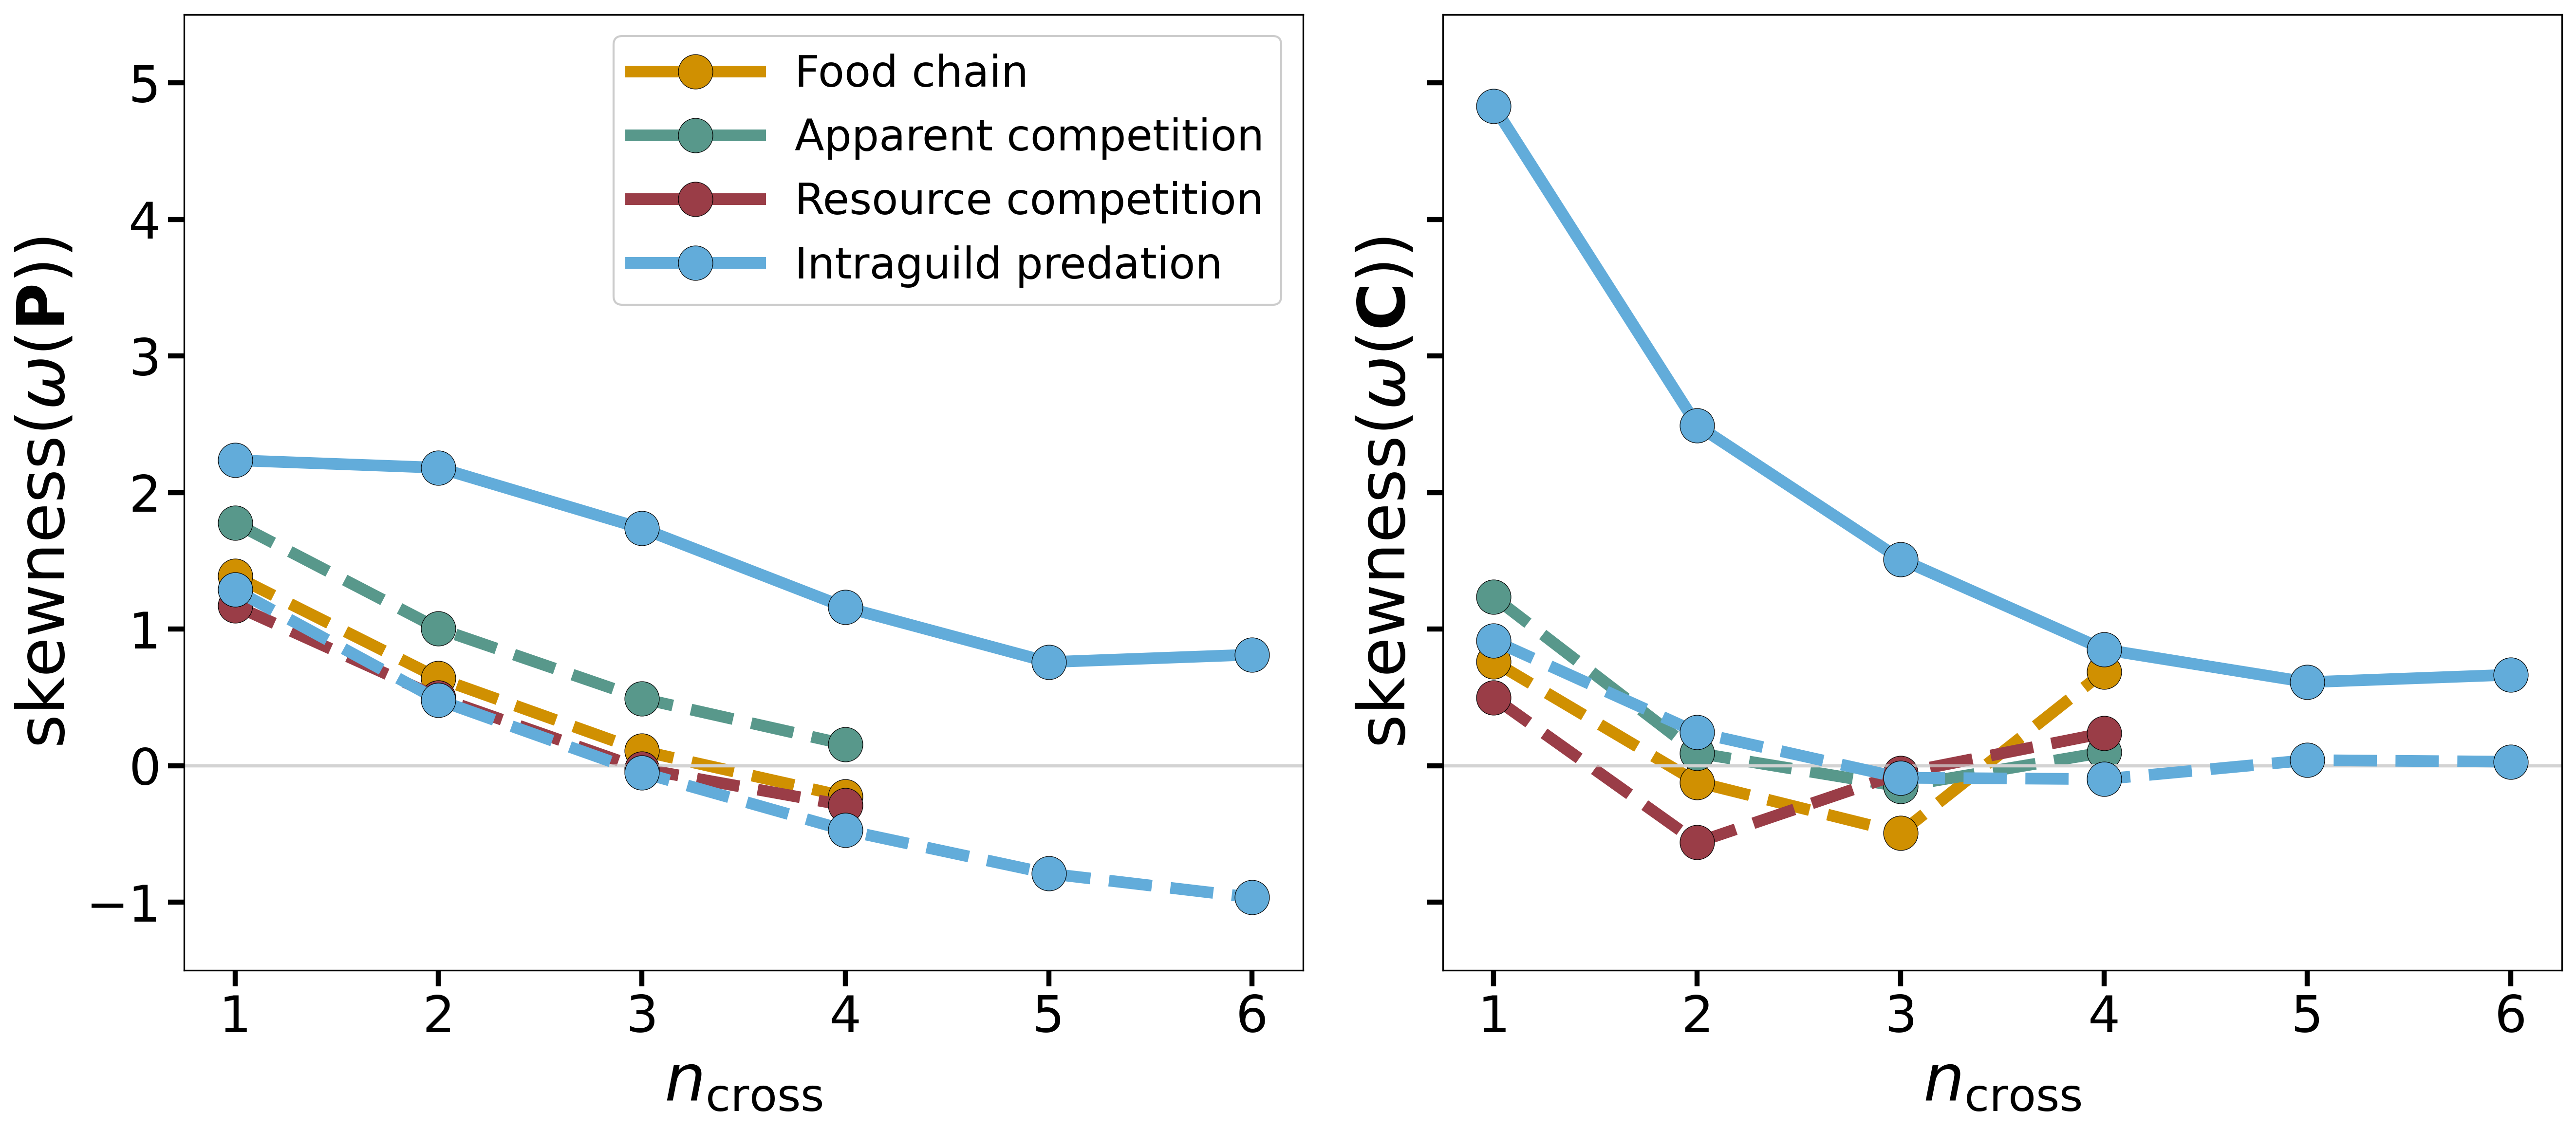

In [435]:
savefig = True
# figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
# figfn = 'robustness_skewness.png'
figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/final/'
figfn = 'supp1.pdf'
# Set new module labels because they've changed
modules_new = ['Food chain', 'Apparent competition', 'Resource competition', 'Intraguild predation']
letters = [r'$\left(\rm a\right)$', r'$\left(\rm b\right)$', 
           r'$\left(\rm c\right)$', r'$\left(\rm d\right)$']
let_x = -0.2
let_y = 1.0
num_bins = 25
axfontsize = 32
markersize = 17
linewidth = 5.75
ticklabelsize = 25
ticklength = 8
tickwidth = 2.5
markeredgewidth = 0.3
colors = ['#D09001', '#58988B', '#9A3D47', '#62ACDA']
dpi = 300
fig, axs = plt.subplots(1, 2, figsize=(10.5*2, 8.5*1), dpi=dpi)
handles = []; labels = []
with sg.H5Store('robustness.h5').open(mode='r') as rob_data:
    for stat_idx, stat_key in enumerate(['skewness']):
        for module_idx, module in enumerate(modules[[0,2,1,3]]):
            for rob_idx, rob_key in enumerate(['local', 'spatial']):
                col = rob_idx
                axs[col].axhline(0, ls='-', color='lightgrey', alpha=0.7)
                for cons_key in constraint_keys:
                    if (module != 'omnivory') and (cons_key == 'constrained'):
                        if col == 0:
                            line = axs[col].plot([], [], ls='-', lw=linewidth, color=colors[module_idx], 
                                                 zorder=module_idx, marker='o', markersize=markersize, label=label, 
                                                 markeredgecolor='black', markeredgewidth=markeredgewidth)
                            handles.append(line[0]); labels.append(label)
                        continue
                    # stat_data = [rob_data['{}/{}/{}/{}'.format(str(n_cross),stat_key,rob_key,cons_key)] for n_cross in n_cross_arr]
                    data_key = '{}/{}/{}/{}'.format(module,stat_key,rob_key,cons_key)
                    stat_data = np.array(rob_data[data_key])
                    ls = '--' if cons_key == 'unconstrained' else '-'
                    color = 'cornflowerblue'
                    # ax.plot(n_cross_arr[1:], stat_data[1:], ls=ls, color=colors[module_idx], label=cons_key)
                    # ax.scatter(n_cross_arr[1:], stat_data[1:], color=colors[module_idx], alpha=0.8)
                    label = modules_new[module_idx]
                    line = axs[col].plot(n_cross_arr[1:], stat_data[1:], ls=ls, lw=linewidth, color=colors[module_idx], 
                                              zorder=module_idx, marker='o', markersize=markersize, label=label, 
                                              markeredgecolor='black', markeredgewidth=markeredgewidth)
                    if (cons_key == 'constrained') and (rob_idx == 0):
                        handles.append(line[0]); labels.append(label)
                    axs[col].set_xlabel(r'$n_{\rm cross}$', fontsize=axfontsize)
                    if rob_key == 'local':
                        ylabel = '{}'.format(stat_key) + r'$\left(\omega\left(\bf{P}\right)\right)$'
                    else: 
                        ylabel = '{}'.format(stat_key) + r'$\left(\omega\left(\bf{C}\right)\right)$'
                    axs[col].set_ylabel(ylabel, fontsize=axfontsize)
                    # ylim = (0,0.14) if stat_key == 'variance' else (-1,14)
                    ylim = (0,0.15) if stat_key == 'variance' else (-1.5,5.5)
                    axs[col].set_ylim(ylim)
                labelleft = False if col==1 else True
                axs[col].tick_params(labelsize=ticklabelsize, length=ticklength, width=tickwidth, 
                                          labelleft=labelleft)
                # ax.legend()
axs[0].legend(handles, labels, fontsize=ticklabelsize*0.85, framealpha=1, handlelength=3.)
fig.subplots_adjust(wspace=0.125)
if savefig:
    plt.savefig(figpath + figfn, bbox_inches='tight')

## All distributions

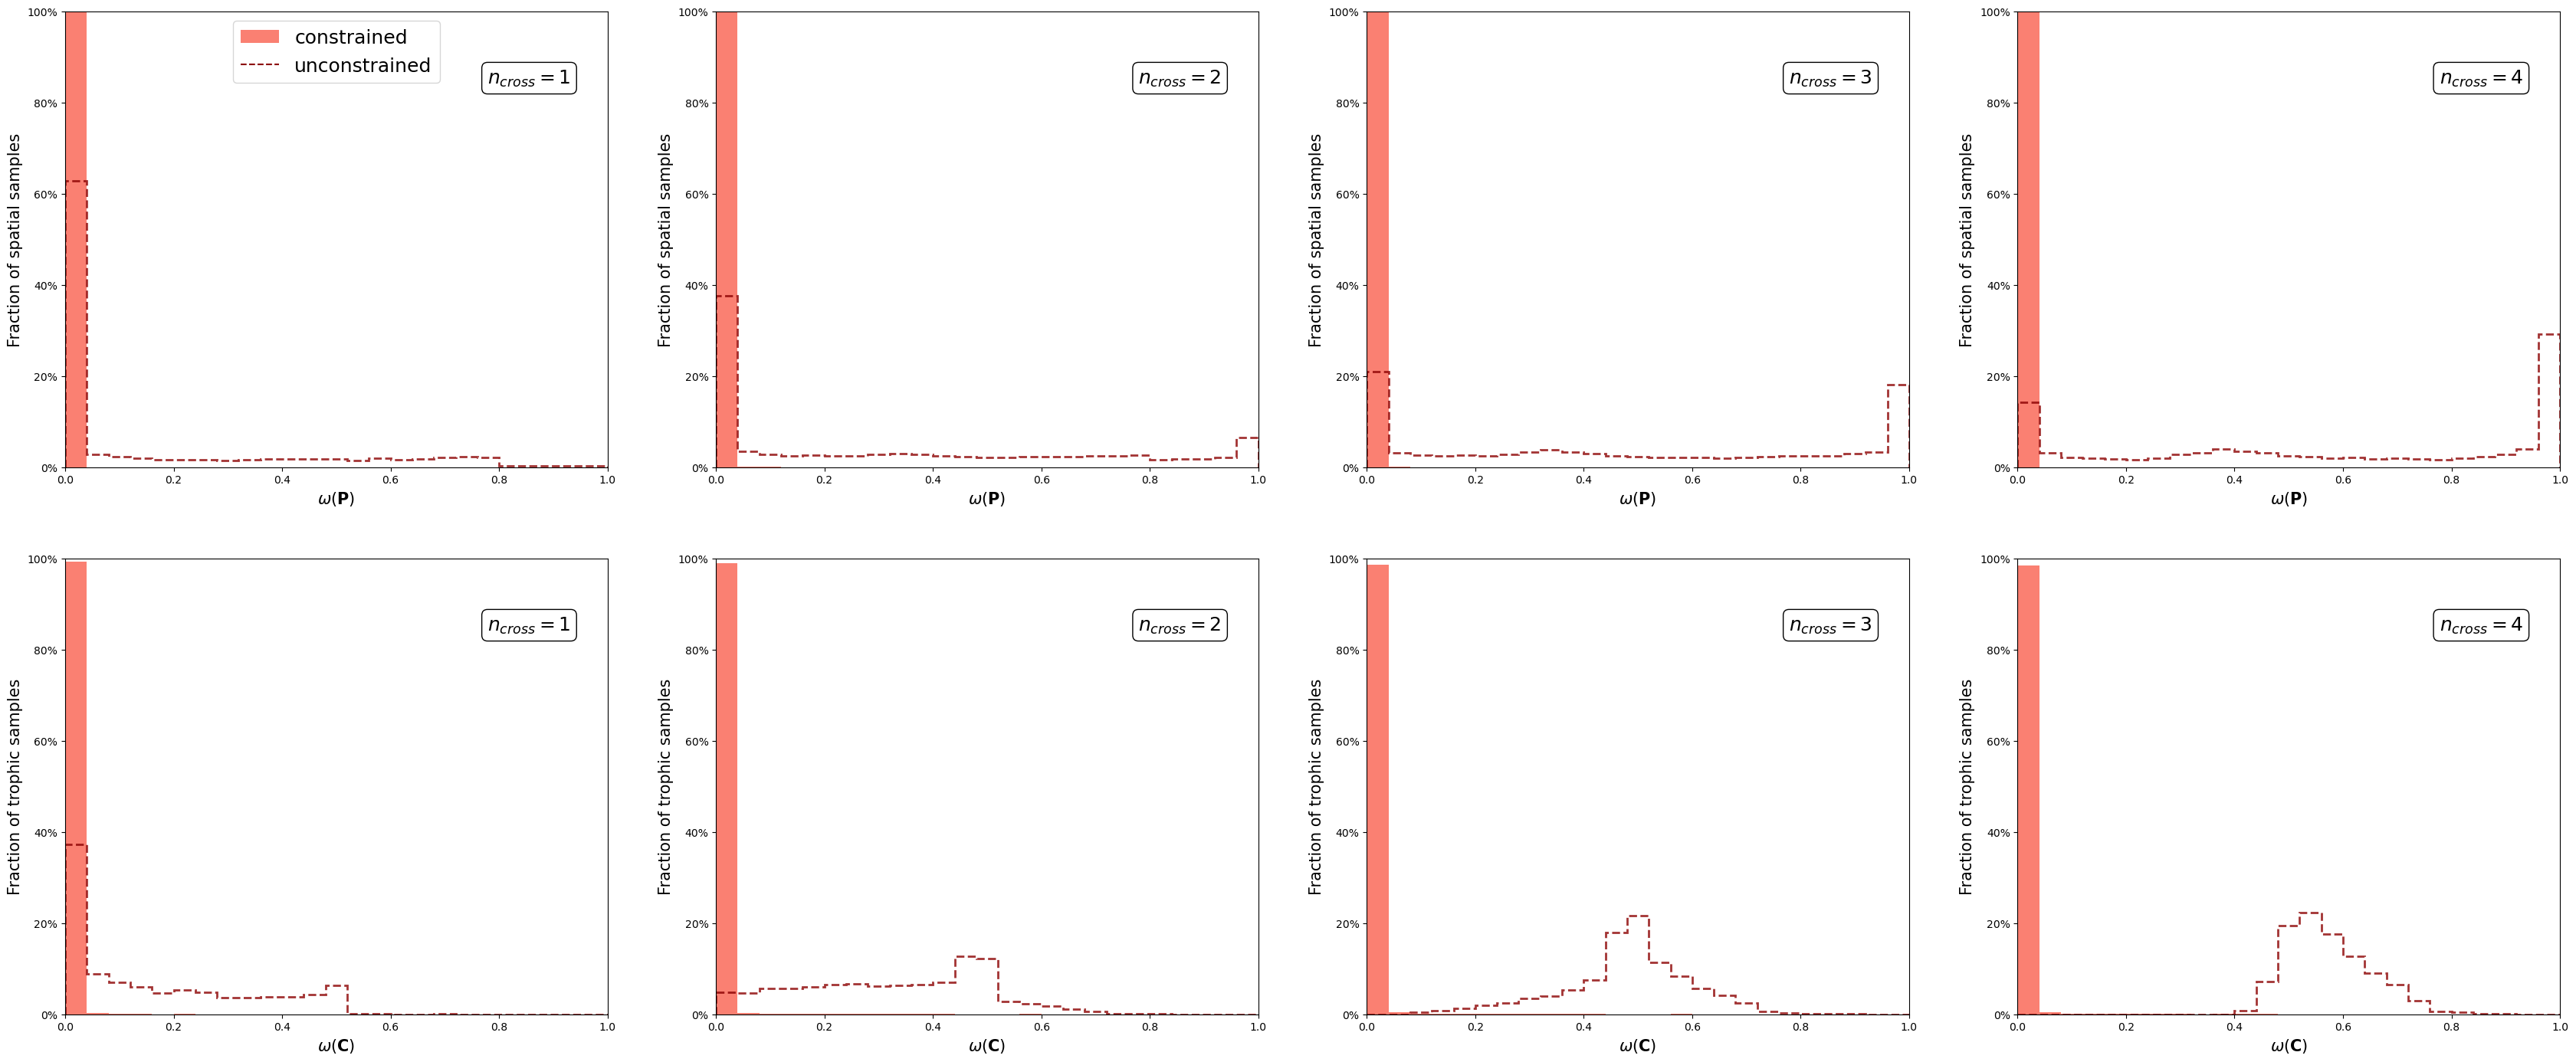

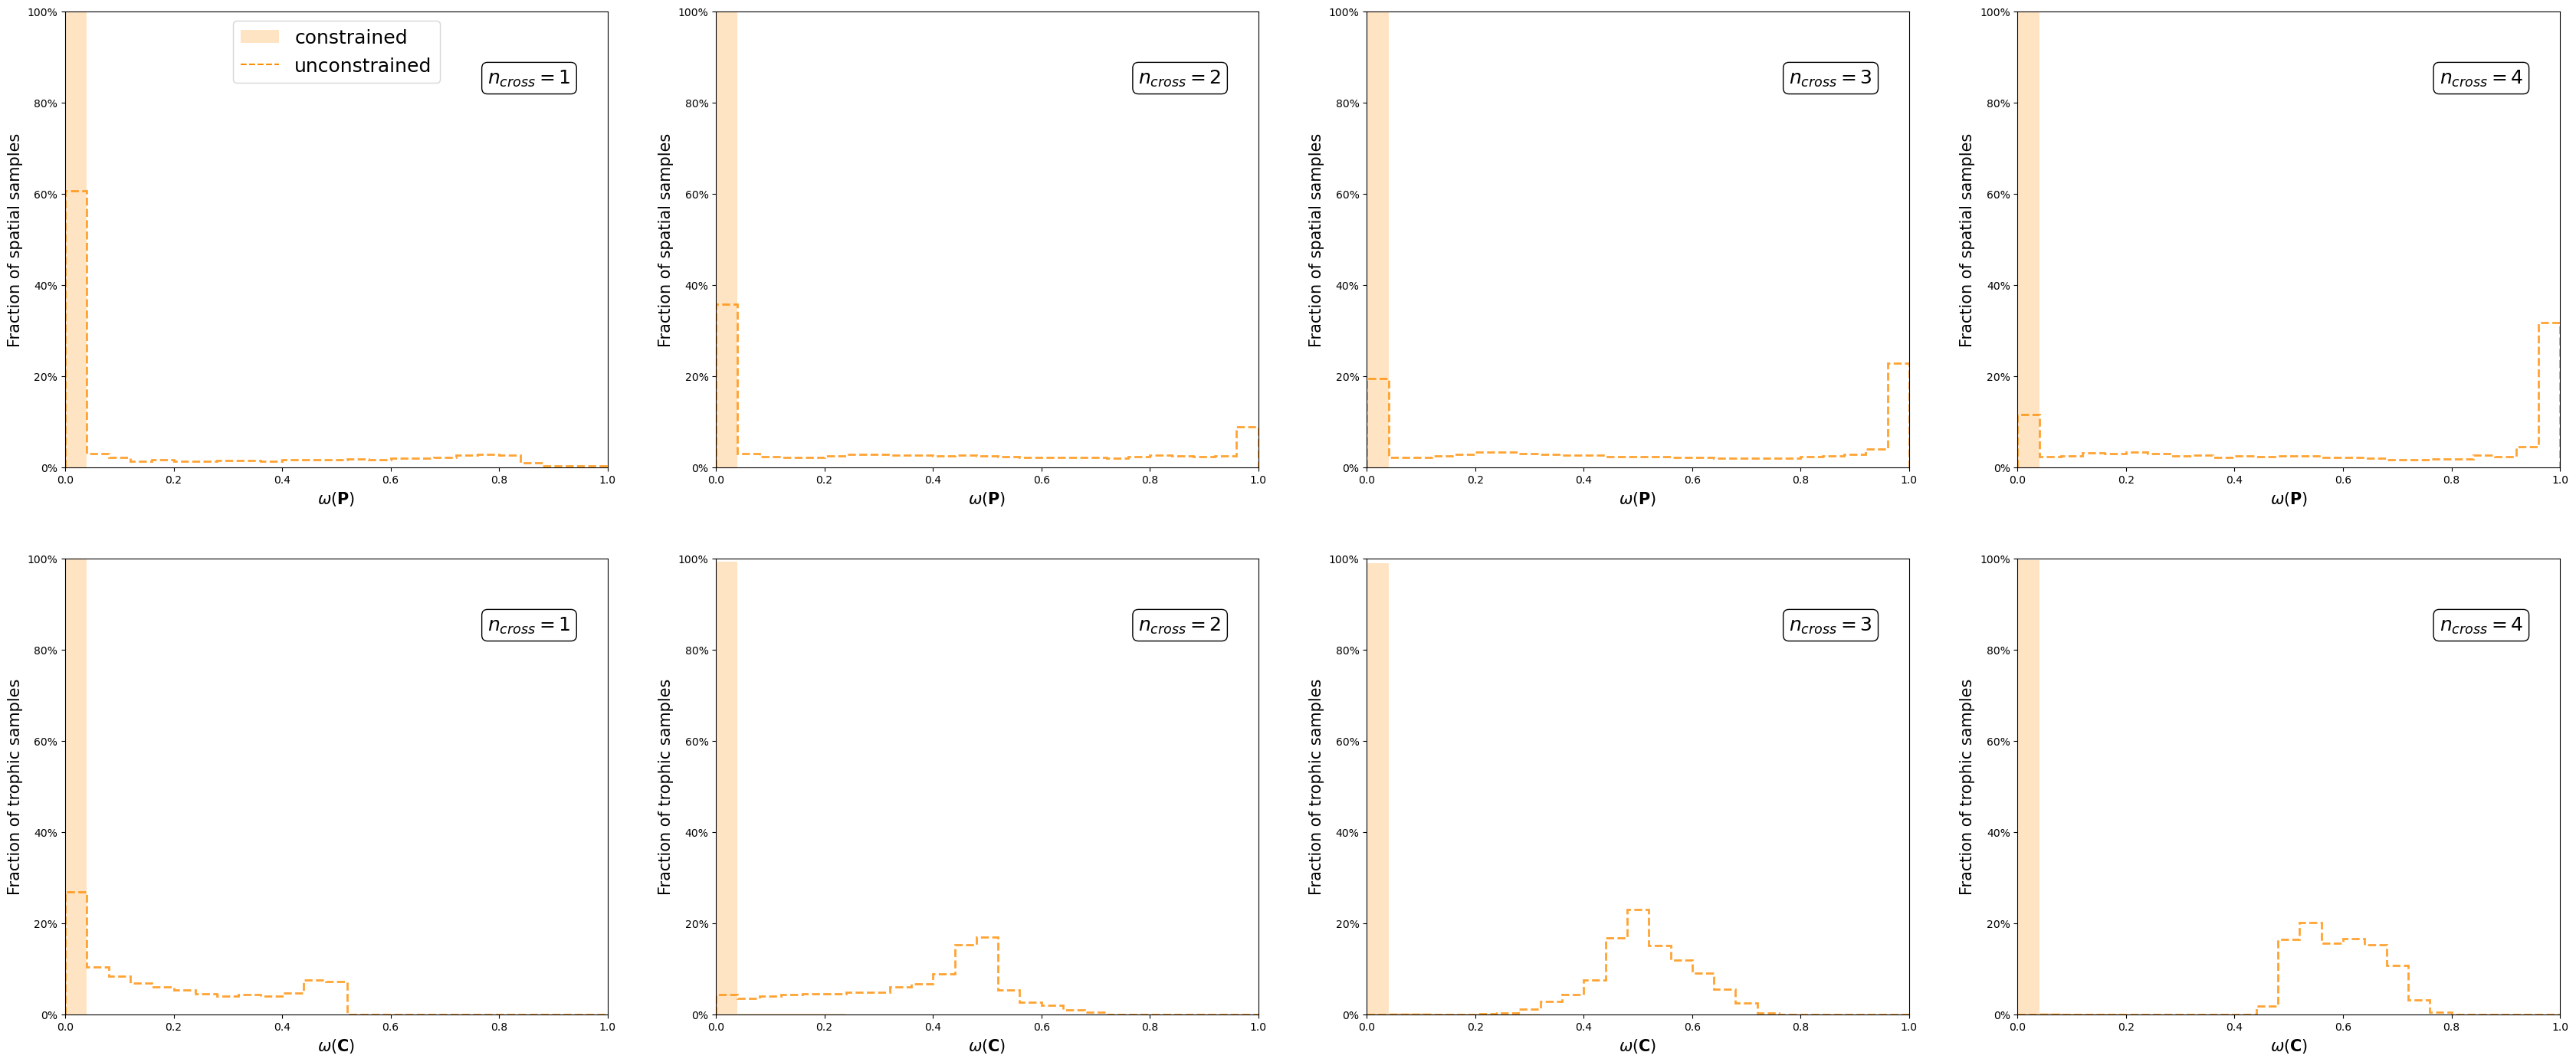

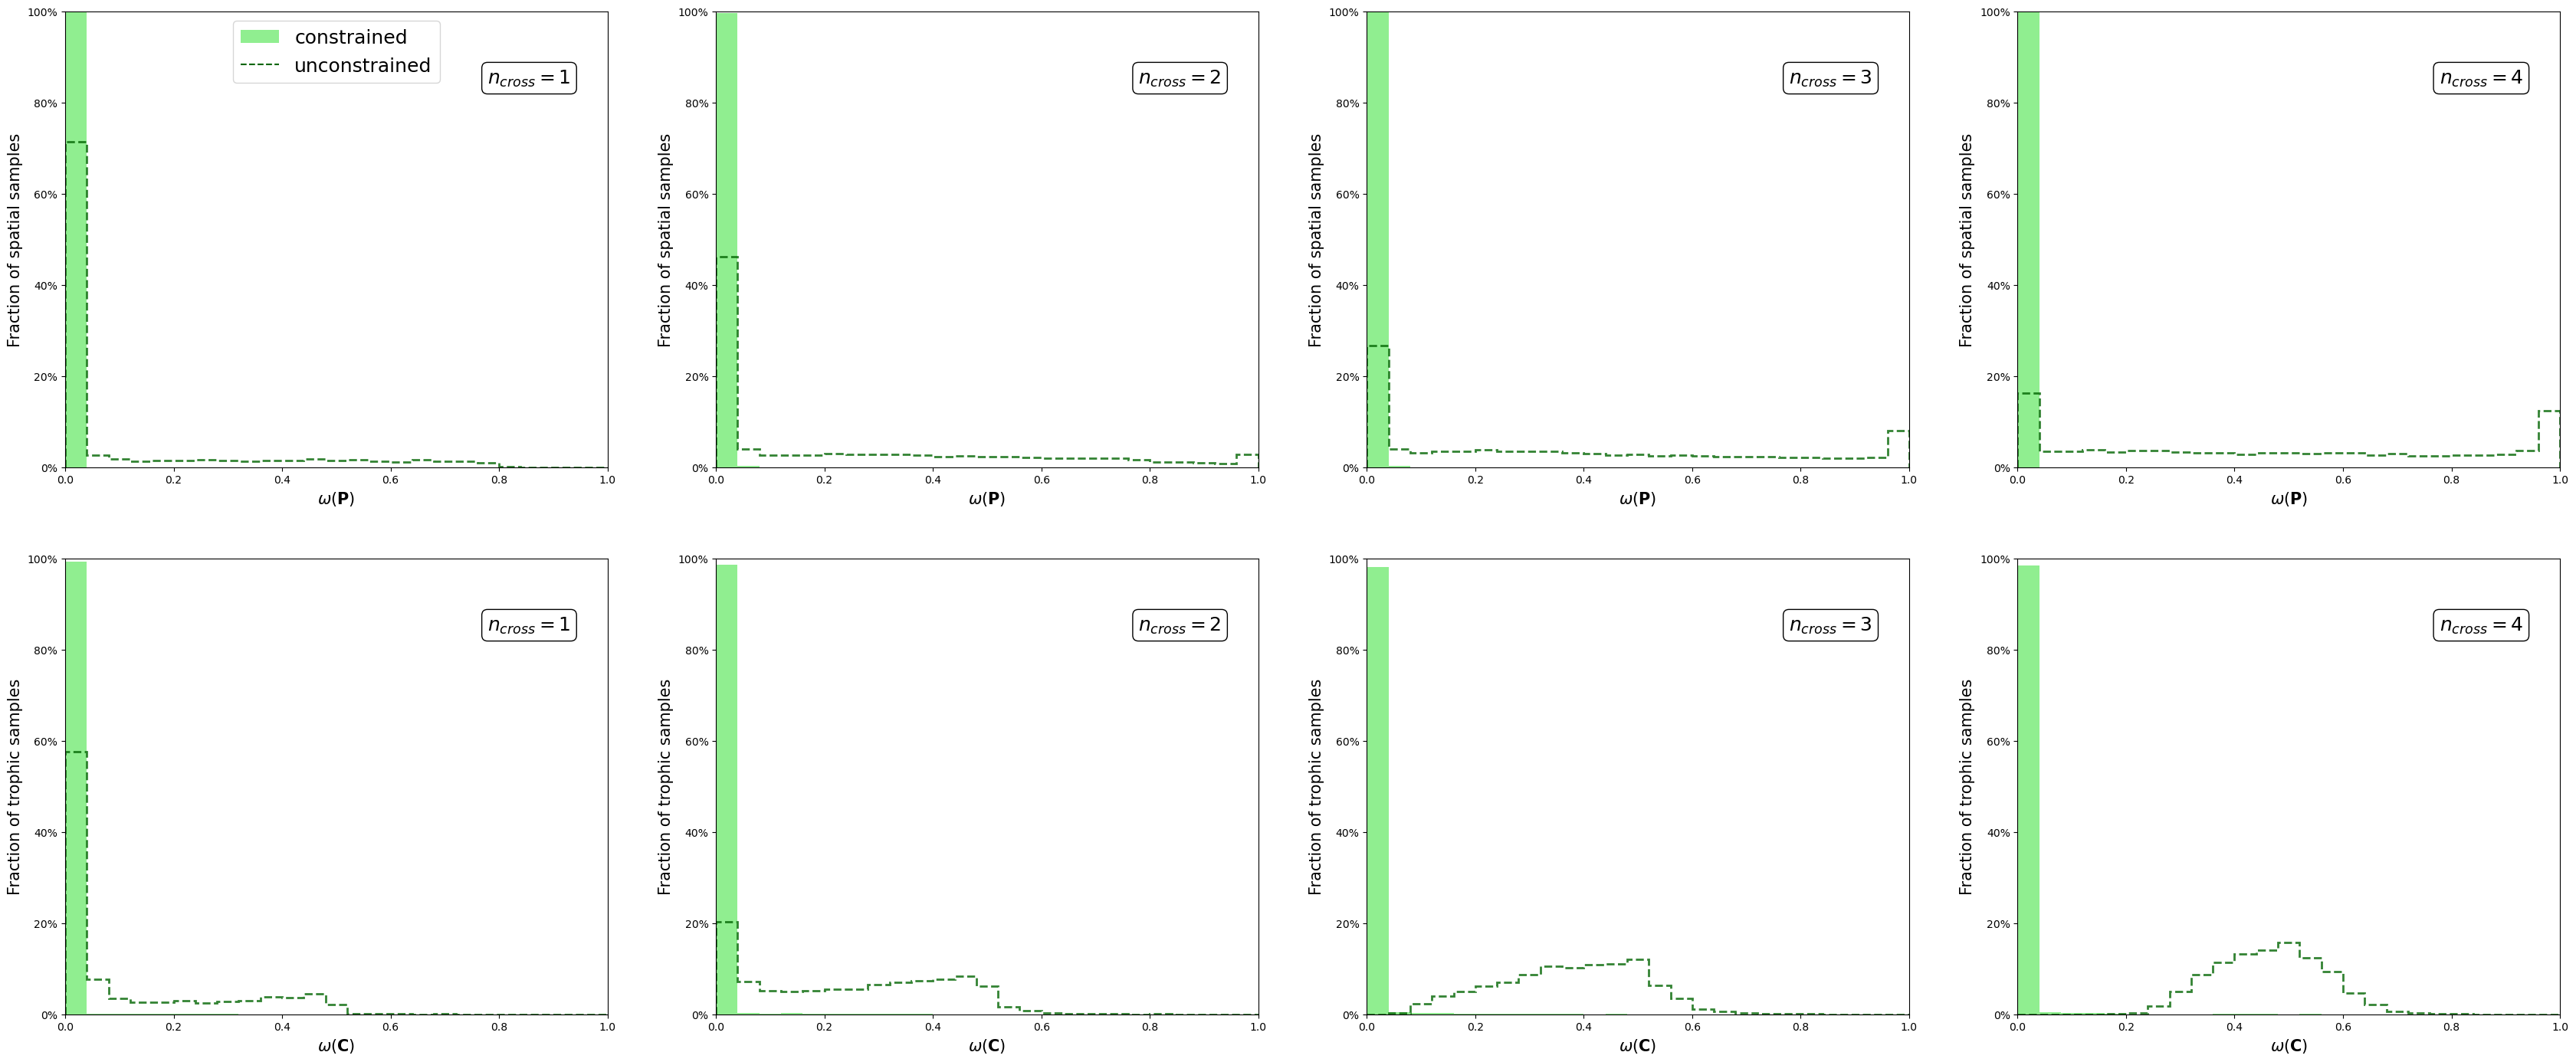

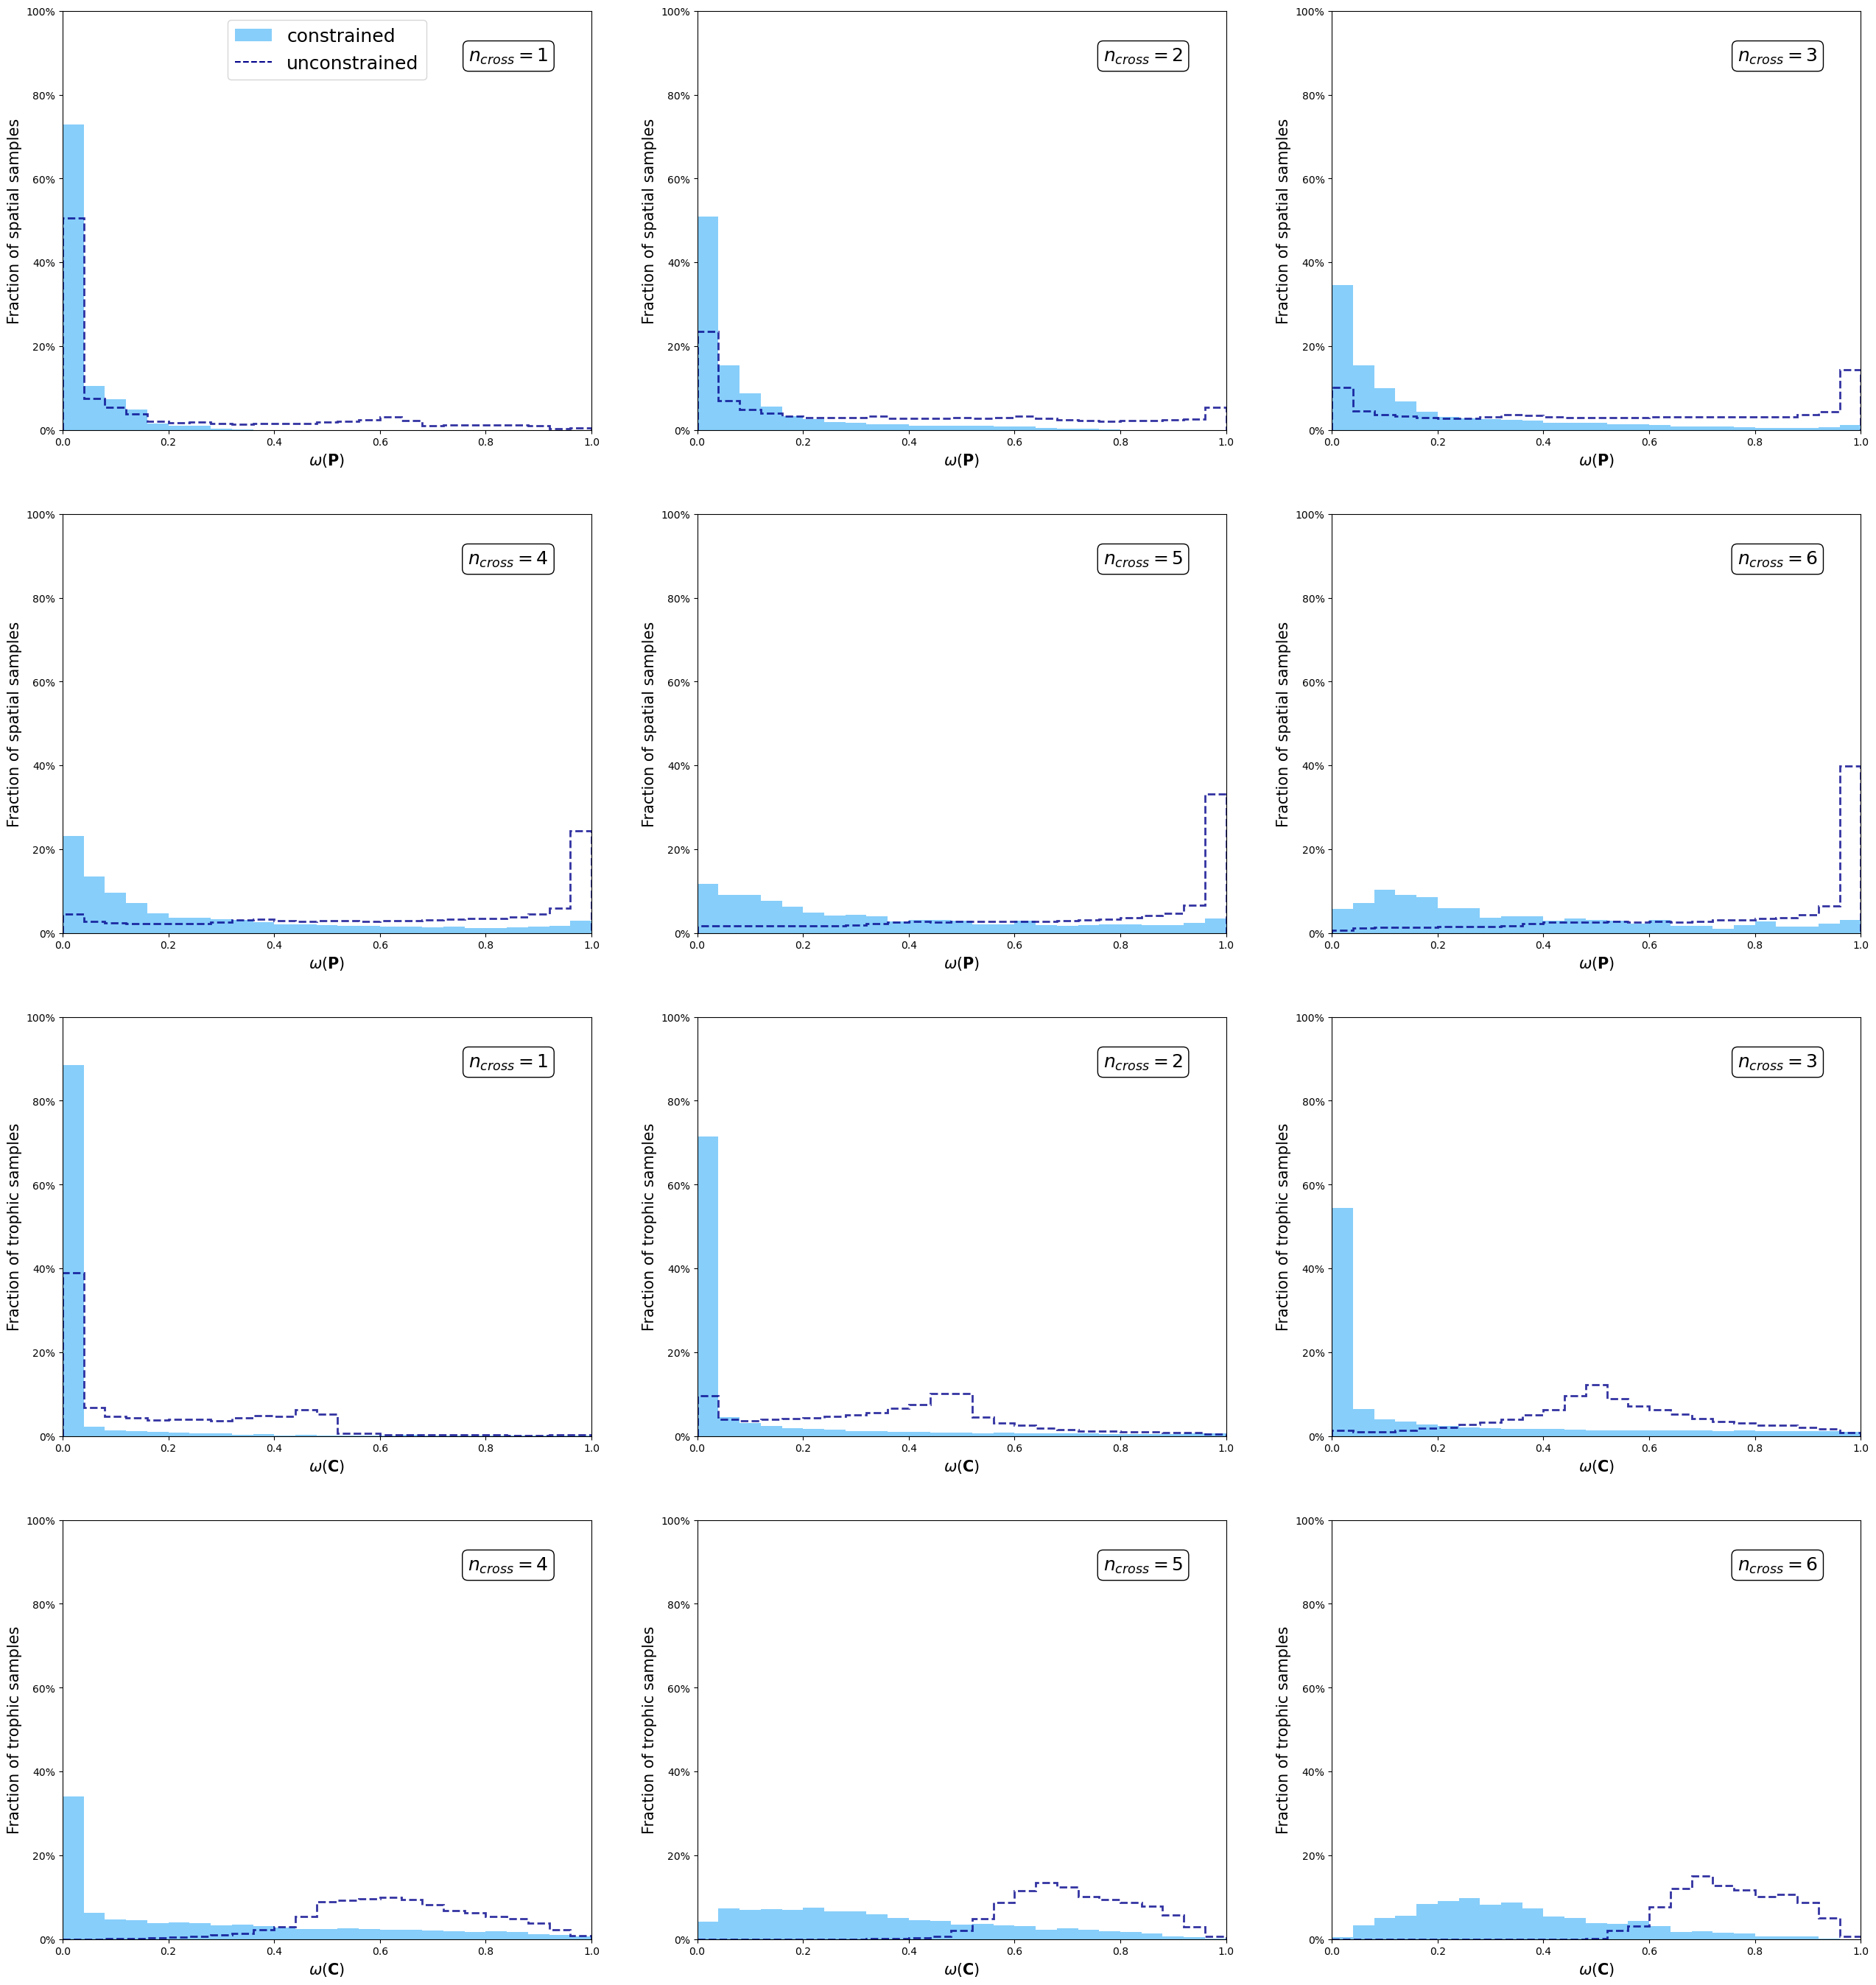

In [110]:
savefig = False
# con_colors = ['red', 'orange', 'green', 'blue']
con_colors = ['salmon', 'bisque', 'lightgreen', 'lightskyblue']
uncon_colors = ['darkred', 'darkorange', 'darkgreen', 'darkblue']
for module_idx, module in enumerate(modules):
    plotall = True
    figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
    figfn = 'robustness_histograms_all_{}.png'.format(module) if plotall else 'robustness_histograms.png'
    rob_keys = ['local', 'spatial']
    if plotall and (module != 'omnivory'):
        plt.figure(figsize=(10.5*4, 8.5*2))
    elif plotall and (module == 'omnivory'):
        plt.figure(figsize=(10.5*3, 8.5*4))
    else:
        plt.figure(figsize=(10.5*2, 8.5*2))
    bins = 25
    axfontsize = 14
    titlefontsize = 16

    n_cross_slice = n_cross_arr[1:] if plotall else [1,6]
    for n_cross in n_cross_slice: 
        if plotall and (module != 'omnivory') and (n_cross >= 5):
            continue
        with sg.H5Store('robustness.h5').open(mode='r') as rob_data:
            for rob_idx, rob_key in enumerate(rob_keys):
                if plotall and (module != 'omnivory'):
                    plt_idx = (n_cross) + (rob_idx*4)
                    ax = plt.subplot(2, 4, int(plt_idx))
                elif plotall and (module == 'omnivory'):
                    plt_idx = (n_cross) + (rob_idx*6)
                    ax = plt.subplot(4, 3, int(plt_idx))
                else:
                    if n_cross == 1:
                        plt_idx = rob_idx * 2 + 1
                    else:
                        plt_idx = rob_idx * 2 + 2
                    ax = plt.subplot(2, 2, int(plt_idx))
                # First plot constrained distribution
                data_key = '{}/robustness/{}/constrained/{}'.format(module,rob_key,str(n_cross))
                data = np.array(rob_data[data_key])
                label = 'constrained' if (n_cross==1) and (rob_idx==0) else ''
                N, bins, patches = ax.hist(data, range=(0,1), bins=bins, 
                                           density=True, histtype='bar', linewidth=2, 
                                           color=con_colors[module_idx], label=label)
                # Now plot unconstrained distribution
                data_key = '{}/robustness/{}/unconstrained/{}'.format(module,rob_key,str(n_cross))
                data = np.array(rob_data[data_key])
                label = 'unconstrained' if (n_cross==1) and (rob_idx==0) else ''
                ax.hist(data, range=(0,1), bins=bins, 
                        density=True, histtype='step', linewidth=2, color=uncon_colors[module_idx], 
                        linestyle='--', alpha=0.8)
                ax.plot([], [], linestyle='--', label=label, color=uncon_colors[module_idx])
                # Set misc plot parameters
                label = r'$n_{{{}}}={{{}}}$'.format('cross',n_cross)
                ax.annotate(label, xy=(475, 375), xycoords='axes points',
                            size=18, ha='right', va='top',
                            bbox=dict(boxstyle='round', fc='w'))
                binsize = bins[1] - bins[0]
                maxN = 1 / binsize
                ax.set_ylim(0, maxN)
                ax.yaxis.set_major_formatter(PercentFormatter(xmax=maxN))
                # ax.semilogx()
                ax.set_xlim(0,1)
                if rob_key == 'local':
                    xlabel = r'$\omega\left(\bf{{{}}}\right)$'.format('P')
                    ylabel = 'Fraction of spatial samples'
                else:
                    xlabel = r'$\omega\left(\bf{{{}}}\right)$'.format('C')
                    ylabel = 'Fraction of trophic samples'
                ax.set_xlabel(xlabel, fontsize=axfontsize+1)
                ax.set_ylabel(ylabel, fontsize=axfontsize+1)
                # ax.set_title(r'$\langle q \rangle=\frac{{{}}}{{6}}$'.format(n_cross), fontsize=titlefontsize)
                # ax.set_title('{} interspecific sensitivity'.format(n_cross), fontsize=axfontsize)
                if (n_cross==1) and (rob_idx==0):
                    ax.legend(loc='upper center', prop={'size': 18})
    if savefig:
        plt.savefig(figpath + figfn, bbox_inches='tight')